In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns #visualisation
import statsmodels.api as sm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
%matplotlib inline 

In [80]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Import data
users = pd.read_csv('takehome_users.csv',encoding = "ISO-8859-1")
engagement = pd.read_csv('takehome_user_engagement.csv',encoding = "ISO-8859-1")

In [3]:
users.shape,engagement.shape

((12000, 11), (207917, 3))

In [4]:
engagement

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
email_domain                  12000 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 1.0+ MB


In [6]:
users.email_domain.nunique()

1184

In [7]:
#the Object_id column represent the same information as the user _id , so we will rename Object_id

In [8]:
users.rename(columns = {'object_id':'user_id'}, inplace = True)

In [9]:
#pd.to_datetime(users.last_session_creation_time).apply(lambda x: x.date())
#pd.to_datetime(users.last_session_creation_time, unit='s')

In [10]:
#Change  creation time,last_session_creation_time,and time stamp to datetime format
users.creation_time = pd.to_datetime(users.creation_time)
users.last_session_creation_time= pd.to_datetime(users.last_session_creation_time, unit='s')
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [11]:
#target definition. Get Adopted users
def moving_count(data, period):
    return data.rolling(period, on='time_stamp')['user_id'].count()
#add column containing counts of how many times a user has logged in, in the last week
engagement['nbr_logins_7days'] = engagement.groupby('user_id', as_index=False, group_keys=False).apply(moving_count, '7D')

In [12]:
engagement.head()

,time_stamp,user_id,visited,nbr_logins_7days
0,2014-04-22 03:53:30,1,1,1.0
1,2013-11-15 03:45:04,2,1,1.0
2,2013-11-29 03:45:04,2,1,1.0
3,2013-12-09 03:45:04,2,1,1.0
4,2013-12-25 03:45:04,2,1,1.0


In [13]:
#for each user id keep row containg highest number of consecutive logins over a period of 1 week
activity = engagement.groupby('user_id')[['nbr_logins_7days']].max()
activity.head()

,nbr_logins_7days
user_id,
1,1.0
2,3.0
3,1.0
4,1.0
5,1.0


#### Add Adopted_user column
We define an "adopted user" as a user who has logged into the product on three separate days in at least one seven-day period

In [14]:
#If 7 day number or logins is <3, set adopted user to 0, otherwise set to 1
activity.loc[activity['nbr_logins_7days']<3,'adopted']=0
activity.loc[activity['nbr_logins_7days']>=3,'adopted']=1
activity.astype('int32').dtypes

nbr_logins_7days    int32
adopted             int32
dtype: object

In [15]:
#total number of adopted and non adopted users
activity['adopted'].value_counts()

0.0    7221
1.0    1602
Name: adopted, dtype: int64

#### Merge User and activity data
nbr_logins_7days and adopted are directly corelated, so we will only keep the adopted variable to avoid issues later in the modelling process
We expect user adoption to be independent of the user's name,email,or the invited_by_user_id therefore we will drop these features

In [16]:
adoption_df=users.merge(activity[['adopted']], how = 'left',on = 'user_id',sort = True)
adoption_df.drop(['user_id','name','email','invited_by_user_id','org_id'],axis=1,inplace=True)
adoption_df.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,email_domain,adopted
0,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,yahoo.com,0.0
1,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,gustr.com,1.0
2,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,gustr.com,0.0
3,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,yahoo.com,0.0
4,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,yahoo.com,0.0


In [17]:
#Add user tenure: Number of days between account creation_time and last_session
adoption_df['tenure_days'] = (adoption_df['last_session_creation_time']-adoption_df['creation_time'])/np.timedelta64(1, 'D')

adoption_df[['last_session_creation_time','creation_time','tenure_days']]

,last_session_creation_time,creation_time,tenure_days
0,2014-04-22 03:53:30,2014-04-22 03:53:30,0.0
1,2014-03-31 03:45:04,2013-11-15 03:45:04,136.0
2,2013-03-19 23:14:52,2013-03-19 23:14:52,0.0
3,2013-05-22 08:09:28,2013-05-21 08:09:28,1.0
4,2013-01-22 10:14:20,2013-01-17 10:14:20,5.0
...,...,...,...
11995,2013-09-06 06:14:15,2013-09-06 06:14:15,0.0
11996,2013-01-15 18:28:37,2013-01-10 18:28:37,5.0
11997,2014-04-27 12:45:16,2014-04-27 12:45:16,0.0
11998,2012-06-02 11:55:59,2012-05-31 11:55:59,2.0


In [18]:
adoption_df.drop(['last_session_creation_time','creation_time'],axis=1,inplace=True)

In [19]:
#count number of users for each domain
adoption_df.email_domain.value_counts()[:10]

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
mumdc.com            2
qgjbc.com            2
luque.com            2
rerwl.com            2
Name: email_domain, dtype: int64

In [20]:
def email_group(x):
    value = 'other'
    if x == 'gmail.com':
        value = 'gmail'
    elif x == 'yahoo.com':
        value = 'yahoo'
    elif x == 'jourrapide.com':
        value = 'jourrapide'
    elif x == 'cuvox.de':
        value =='cuvox'
    elif x == 'gustr.com':
        value = 'gustr'
    elif x== 'hotmail.com':
        value = 'hotmail'
    return value

In [21]:
adoption_df['email_domain']=adoption_df['email_domain'].apply(email_group)


In [22]:
print(adoption_df.email_domain.unique())
adoption_df.email_domain.value_counts()

['yahoo' 'gustr' 'jourrapide' 'hotmail' 'other' 'gmail']


gmail         3562
yahoo         2447
other         2388
jourrapide    1259
gustr         1179
hotmail       1165
Name: email_domain, dtype: int64

In [23]:
#Missing values imputation
adoption_df.adopted.fillna(0,inplace=True)
adoption_df.tenure_days.fillna(adoption_df.tenure_days.mean(),inplace=True)

In [24]:
adoption_df.dtypes

creation_source                object
opted_in_to_mailing_list        int64
enabled_for_marketing_drip      int64
email_domain                   object
adopted                       float64
tenure_days                   float64
dtype: object

ORG_INVITE            553
GUEST_INVITE          360
SIGNUP                293
SIGNUP_GOOGLE_AUTH    232
PERSONAL_PROJECTS     164
Name: creation_source, dtype: int64


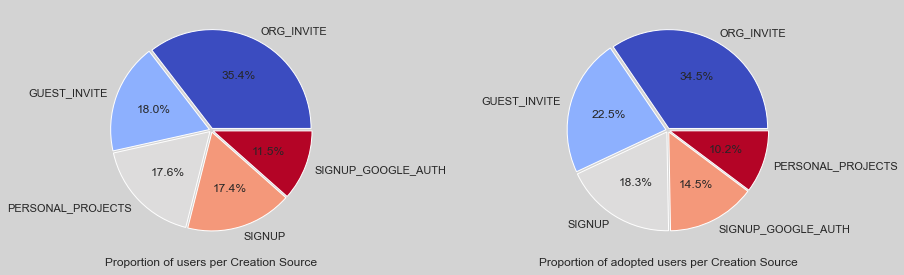

In [434]:
fig = plt.figure(figsize = (15,10))
fig.patch.set_facecolor('lightgrey')
sns.set(font_scale =1)
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
#ax3 = fig.add_subplot(2,2,3)
#sns.countplot(data = adoption_df, x='creation_source',order=adoption_df['creation_source'].value_counts().index,ax=ax1,palette='colorblind')

adoption_df['creation_source'].value_counts().plot(kind='pie', autopct='%1.1f%%',explode=(0.02, 0.02, 0.02, 0.02,0.02),ax=ax1,cmap="coolwarm")
ax1.set_xlabel("Proportion of users per Creation Source")
ax1.set_ylabel(None)
adopted_counts=adoption_df.loc[adoption_df['adopted']==1].creation_source.value_counts()
adopted_counts.plot(kind='pie', autopct='%1.1f%%',explode=(0.02, 0.02, 0.02, 0.02,0.02),ax=ax2,cmap='coolwarm')
ax2.set_xlabel("Proportion of adopted users per Creation Source")
ax2.set_ylabel(None)
print(adopted_counts)

#sns.countplot(data = adoption_df, x='creation_source',hue='adopted',ax=ax3)
#adoption_df['email_domain'].value_counts().plot(kind='pie', autopct='%1.1f%%',explode=(0.05, 0.05, 0.05, 0.05,0.05,0.05),shadow=True,ax=ax3,style='tableau-colorblind10')

plt.savefig('adoption.jpeg',dpi=300)

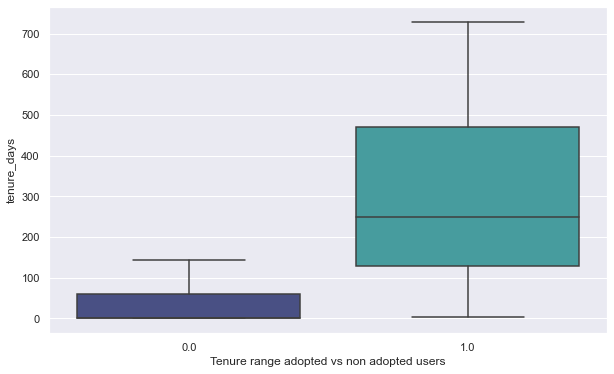

In [441]:
# sns.swarmplot(x="tenure_days", data=adoption_df,hue='creation_source')
fig2 = plt.figure(figsize = (10,6))
fig2.patch.set_facecolor
ax4 = fig2.add_subplot(1,1,1)
#ax5 = fig2.add_subplot(1,2,2)
sns.boxplot( y="tenure_days",x= 'adopted', data=adoption_df,ax=ax4,showfliers=False,palette="mako")
ax4.set_xlabel("Tenure range adopted vs non adopted users")
plt.savefig('tenure_adopted_users.jpeg',dpi=300)

In [431]:
# interval_range = pd.interval_range(start=0, freq=14, end=759)
# adoption_df['tenureBins'] =pd.cut(adoption_df['tenure_days'],interval_range,duplicates='drop')
adoption_df['tenureBins'] =pd.cut(adoption_df['tenure_days'],bins=[0,7,15,45,60,90,120,180,280,759],duplicates='drop')

adoption_df[['tenure_days', 'tenureBins']].head() 
# adoption_df
# interval_range

,tenure_days,tenureBins
0,0.0,NaN
1,136.0,"(120.0, 180.0]"
2,0.0,NaN
3,1.0,"(0.0, 7.0]"
4,5.0,"(0.0, 7.0]"


<Figure size 720x720 with 0 Axes>

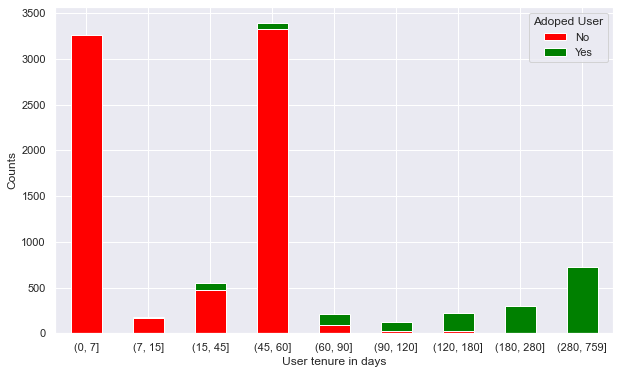

In [439]:
#Plot Proportion of adopted users per tenure bin
plt.figure(figsize=(10, 10))
df_plot = adoption_df.groupby(['tenureBins', 'adopted']).size().reset_index().pivot(columns='adopted', index='tenureBins', values=0)

g=df_plot.plot(kind='bar',stacked=True,colors=["red","green"],figsize=(10, 6))
plt.xticks(rotation =0)
#g.set_yscale("log")
g.legend(bbox_to_anchor=(1,1),title='Adoped User', labels=['No', 'Yes'])
plt.ylabel("Counts")
plt.xlabel("User tenure in days")
plt.savefig('adoption_reate.jpeg',dpi=300)

<Figure size 720x720 with 0 Axes>

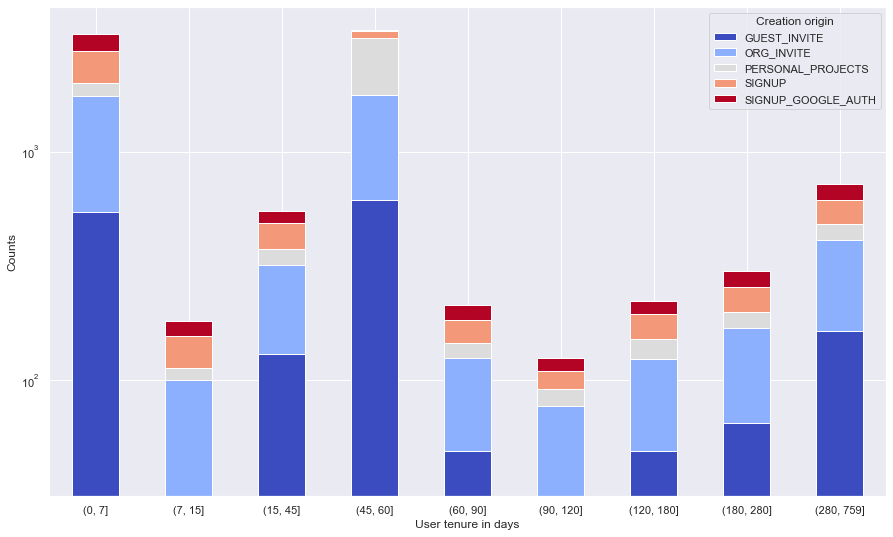

In [444]:
plt.figure(figsize=(10, 10))
df_plot2 = adoption_df.groupby(['tenureBins', 'creation_source']).size().reset_index().pivot(columns='creation_source', index='tenureBins', values=0)

g2=df_plot2.plot(kind='bar',stacked=True,cmap='coolwarm',figsize=(15, 9))
plt.xticks(rotation =0)
g2.set_yscale("log")
g2.legend(bbox_to_anchor=(1,1),title='Creation origin')
plt.ylabel("Counts")
plt.xlabel("User tenure in days")
plt.savefig('tenure_adoption_rate_groups.jpeg',dpi=800)

#### Modelling

In [160]:
# Transform categorical variables to numerical via one hot encoding
adoption_model=pd.get_dummies(adoption_df, columns = ['enabled_for_marketing_drip','opted_in_to_mailing_list','creation_source','email_domain'],drop_first=True)

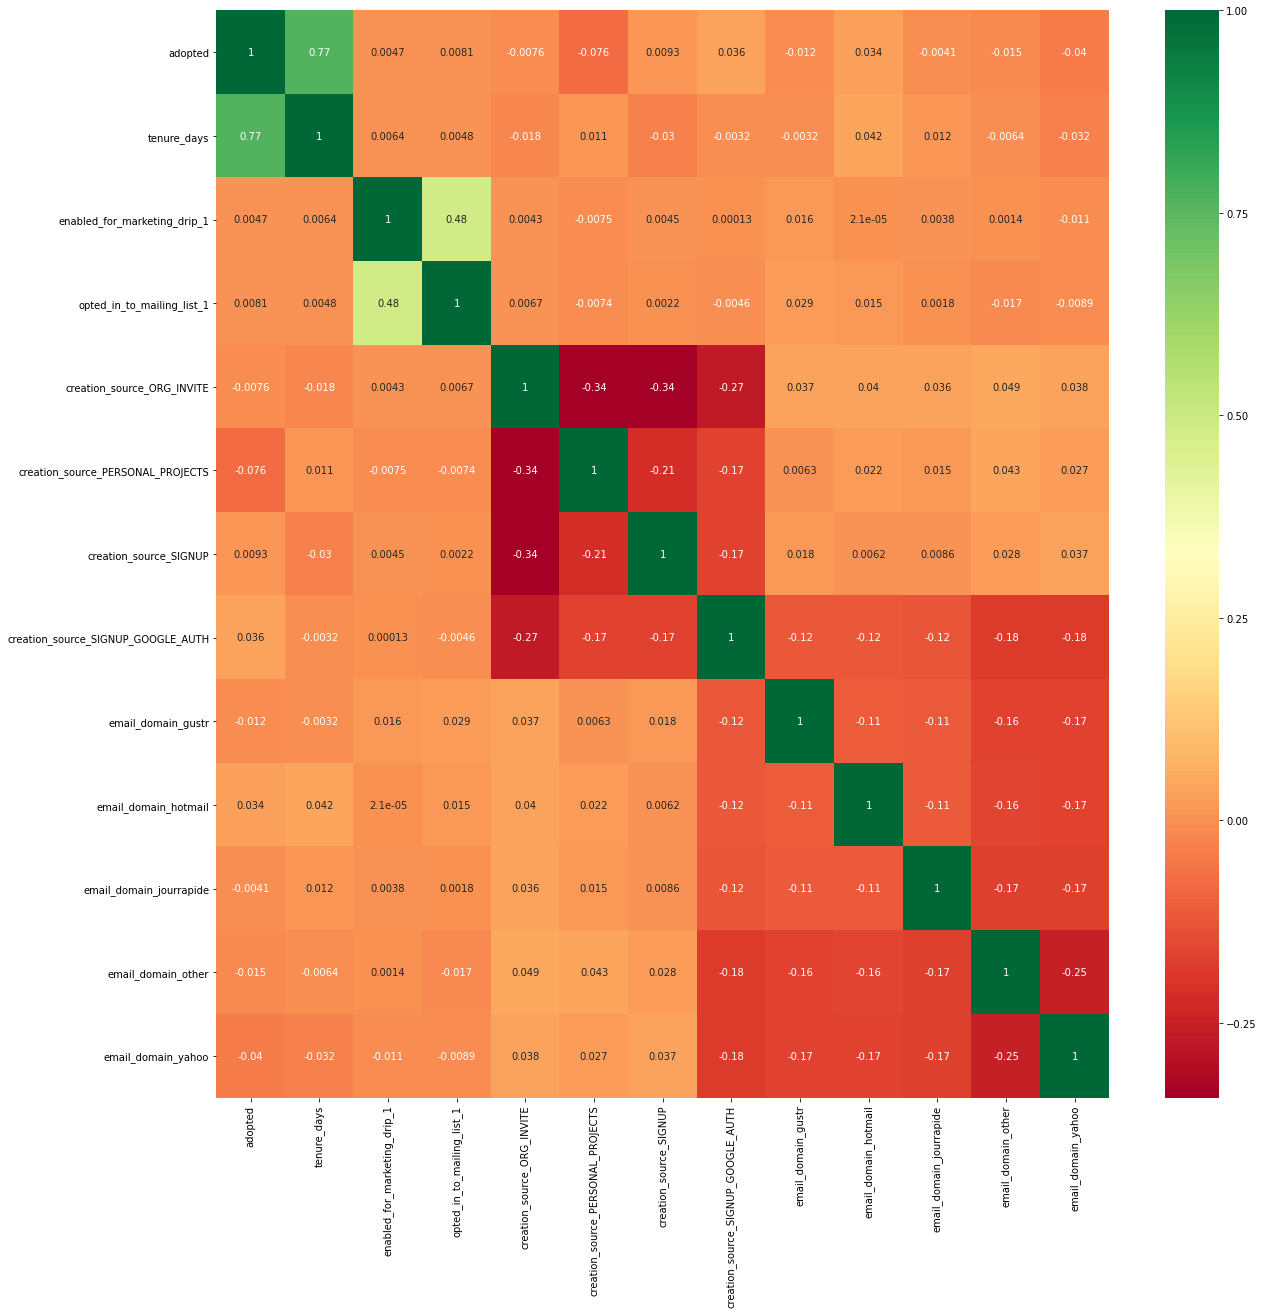

In [29]:
import seaborn as sns
#get correlations of each features in dataset
corrmat = adoption_model.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(adoption_model[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.savefig('variable correlation.png')

In [30]:
#Define dependent and response variables
X = adoption_model.drop(['adopted'], axis=1)
#X=adoption_model[['tenure_days']]
y = adoption_model['adopted']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=66)
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
# random forest model creation
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
# predictions
y_pred = rf_model.predict(X_test)

C:\Users\suzet\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [32]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      3138
         1.0       0.86      0.86      0.86       462

    accuracy                           0.96      3600
   macro avg       0.92      0.92      0.92      3600
weighted avg       0.96      0.96      0.96      3600



In [34]:
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)

tenure_days                           0.968361
opted_in_to_mailing_list_1            0.004550
creation_source_PERSONAL_PROJECTS     0.003777
creation_source_ORG_INVITE            0.003409
creation_source_SIGNUP                0.003343
enabled_for_marketing_drip_1          0.003260
email_domain_yahoo                    0.003031
email_domain_hotmail                  0.002484
creation_source_SIGNUP_GOOGLE_AUTH    0.002377
email_domain_other                    0.002247
email_domain_gustr                    0.001858
email_domain_jourrapide               0.001303
dtype: float64


In [43]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
xgb_model =  LogisticRegression(random_state=0)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

0.9680555555555556


C:\Users\suzet\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [41]:
print(classification_report(y_test,y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      3138
         1.0       0.94      0.81      0.87       462

    accuracy                           0.97      3600
   macro avg       0.95      0.90      0.92      3600
weighted avg       0.97      0.97      0.97      3600

